In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os
from shutil import move, copy
from ultralytics import YOLO

In [10]:
df = pd.read_csv('../data/interim/annots_imgs_merged.csv')
line = df[df['chart-type'] == 'line']
line = line.head(5000)
line = line[['chart-type','data-series','visual-elements.lines','file_name', 'image_path']]
line = line.reset_index(drop=True)
line.columns = ['type','data_series','data','name','path']
line.head()


,type,data_series,data,name,path
0,line,"[{'x': 'Afghanistan', 'y': 97.39144067786003},...","[[{'x': 79.0, 'y': 118.98393922747988}, {'x': ...",a2858b17f9de,../data/interim/Lineplots/a2858b17f9de.jpg
1,line,"[{'x': '1990', 'y': 460139.397945082}, {'x': '...","[[{'x': 112.66666666666667, 'y': 116.484848484...",2208375c43e9,../data/interim/Lineplots/2208375c43e9.jpg
2,line,"[{'x': '0', 'y': 20.138269927536232}, {'x': '2...","[[{'x': 205.33333333333334, 'y': 270.077777777...",49e8a20490e8,../data/interim/Lineplots/49e8a20490e8.jpg
3,line,"[{'x': 'United Kingdom', 'y': 312370881.669299...","[[{'x': 92.0, 'y': 130.25}, {'x': 130.5, 'y': ...",bb52cf8971a1,../data/interim/Lineplots/bb52cf8971a1.jpg
4,line,"[{'x': 'Lithuania', 'y': 25.360055676098174}, ...","[[{'x': 86.66666666666667, 'y': 201.8333333333...",edf075ca7f11,../data/interim/Lineplots/edf075ca7f11.jpg


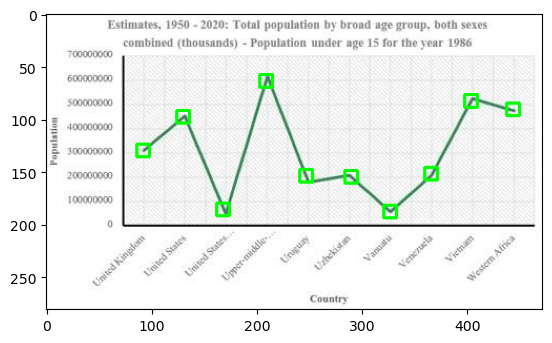

In [8]:
coords = line['data'][3]
coords = coords.replace("'", "\"")
coords_list = json.loads(coords)

    # extract important image info
path = line['path'][3]
name = line['name'][3]
img = cv2.imread(path)
height = img.shape[0]
width = img.shape[1]

    # Save the xy coords into a list
xy_coords = []
for data_point in coords_list[0]:
    xy_coords.append((data_point['x']-6,
                      data_point['y']-6,
                      data_point['x']+6,
                      data_point['y']+6))
    
scatter_img = img.copy()
for bbox in xy_coords:
            x1, y1, x2, y2 = bbox
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            cv2.rectangle(scatter_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(scatter_img)
plt.show()

In [11]:
dataframes = []
for i in range(len(line)):
    # extract xy coordinates from data_coords column
    coords = line['data'][i]
    coords = coords.replace("'", "\"")
    coords_list = json.loads(coords)

    # extract important image info
    path = line['path'][i]
    name = line['name'][i]
    img = cv2.imread(path)
    height = img.shape[0]
    width = img.shape[1]

    # Save the xy coords into a list
    xy_coords = []
    for data_point in coords_list[0]:
        xy_coords.append((data_point['x'],data_point['y']))

    # Transform the xy coords into YOLO bboxes 
    bboxes = []
    for xy in xy_coords:
        x, y = xy
        bbox = (int(x)/width, int(y)/height, 12/width, 12/height)
        bboxes.append(bbox)

    # Save into list of dataframe
    yolo = pd.DataFrame(bboxes, columns=['x','y','w','h'])
    yolo['class'] = 0
    yolo['path'] = path
    yolo['name'] = name
    yolo = yolo[['path','name','class','x','y','w','h']]
    dataframes.append(yolo)

# Concat dataframes and check that the number of unique images is correct
yolo_df = pd.concat(dataframes)
yolo_df['path'].nunique()

5000

In [12]:
unique_images = yolo_df['path'].unique()
img_df = pd.DataFrame(unique_images,columns=['path'])
img_train = tuple(img_df.sample(frac=0.8)['path'])
img_test = tuple(img_df.query(f'path not in {img_train}')['path'])
len(img_train), len(img_test)

(4000, 1000)

In [13]:
train_df = yolo_df.query(f'path in {img_train}')
test_df = yolo_df.query(f'path in {img_test}')

In [18]:
src_folder = '../data/interim/Lineplots/'
train_folder = '../data/YOLO/Lineplots/train/'
test_folder = '../data/YOLO/Lineplots/test/'

In [15]:
cols = ['name','class','x','y','w','h']
groupby_obj_train = train_df[cols].groupby('name')
groupby_obj_test = test_df[cols].groupby('name')

In [16]:
def save_data(filename, folder_path, group_obj):
    #copy image
    src = os.path.join(src_folder,filename)+'.jpg'
    dst = os.path.join(folder_path, filename)+'.jpg'
    copy(src, dst)

    #save labels
    text_filename = os.path.join(folder_path,filename+'.txt')
    group_obj.get_group(filename).set_index('name').to_csv(text_filename, index=False, header=False, sep=' ')

In [20]:
filename_series = pd.Series(groupby_obj_train.groups.keys())
filename_series.apply(save_data,args=(train_folder, groupby_obj_train))

0       None
1       None
2       None
3       None
4       None
        ... 
3995    None
3996    None
3997    None
3998    None
3999    None
Length: 4000, dtype: object

In [21]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data,args=(test_folder, groupby_obj_test))

0      None
1      None
2      None
3      None
4      None
       ... 
995    None
996    None
997    None
998    None
999    None
Length: 1000, dtype: object